In [ ]:
#|default_exp sgd

# Accelerated SGD

In [6]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 15.4 MB/s eta 0:00:00


In [7]:
#|export
import torch

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [8]:
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

In [9]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [10]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## Optimizers

### SGD

In [12]:
class SGD:
    def __init__(self, params, lr, wd=0.):
        params = list(params) # model.parameters() returns a generator so we wrap with list()
        fc.store_attr() 
        self.i = 0 # which batch number we are currently in 

    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p) # regularization step 
                self.opt_step(p)
        self.i +=1

    def opt_step(self, p): p -= p.grad * self.lr
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [13]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD) # 0.4 is a pretty high lr so that's pretty cool

accuracy,loss,epoch,train
0.772,0.640,0,train
0.824,0.477,0,eval
0.845,0.424,1,train
0.849,0.419,1,eval
0.865,0.372,2,train
0.847,0.410,2,eval


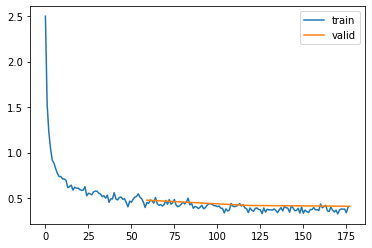

In [14]:
learn.fit(3)

L2 regularization: we add the sum of the square of the weights (time wd factor) to the loss function. So the derivative of that is: 
``` python
2*wd*weight
```
which we add to the gradient

Consider the difference between *weight decay* and *L2 regularization*:

``` python
weight -= lr*wd*weight
```
(which is what we do in the SGD class)

...vs...

``` python
weight.grad += wd*weight
```

### Momentum

In [15]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

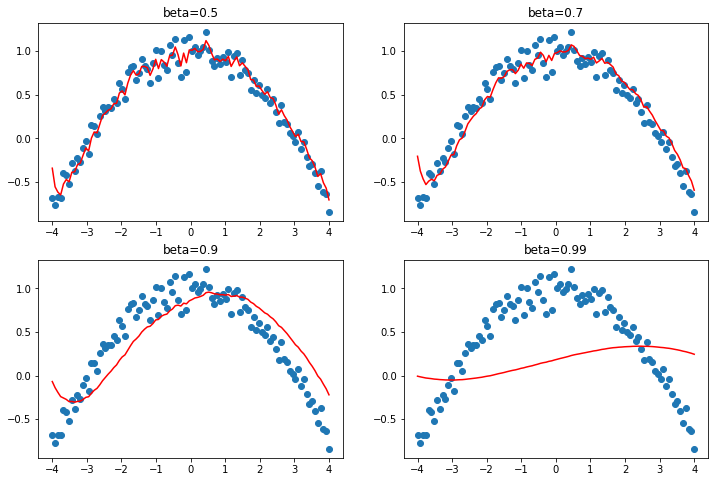

In [16]:
_,axs = plt.subplots(2,2, figsize=(12,8))
betas = [0.5,0.7,0.9,0.99]
for beta,ax in zip(betas, axs.flatten()):
    ax.scatter(xs,ys)
    avg,res = 0,[]
    for yi in ys:
        avg = beta*avg + (1-beta)*yi # we could have implemented this using lerp
        res.append(avg)
    ax.plot(xs,np.array(res), color='red');
    ax.set_title(f'beta={beta}')

In [17]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0., mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom=mom

    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)  # since we're looping through each parameter in the step function, 
                                                                              # we can simply  add a new attribute to the parameter
        p.grad_avg = p.grad_avg*self.mom + p.grad*(1-self.mom)
        p -= self.lr * p.grad_avg

In [18]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum) # it's interesting that we can now really hike the lr to 1.5 thanks to momentum

accuracy,loss,epoch,train
0.787,0.597,0,train
0.847,0.417,0,eval
0.869,0.359,1,train
0.865,0.364,1,eval
0.886,0.313,2,train
0.869,0.359,2,eval


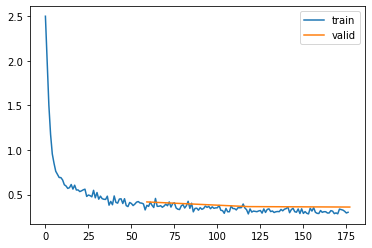

In [19]:
learn.fit(3)

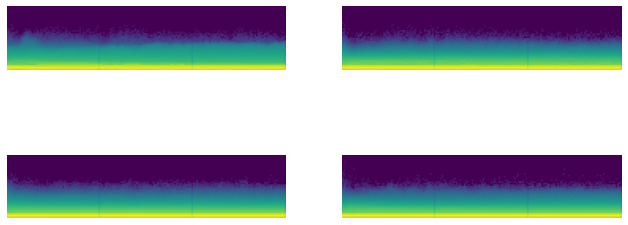

In [20]:
astats.color_dim()

### RMSProp

In [21]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom,self.eps = sqr_mom,eps

    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad**2 # we don't initialize to zeros otherwise in the first steps we will 
                                                            #   divide by a very small number and so the weights will become very high
        p.sqr_avg = p.sqr_avg*self.sqr_mom + p.grad**2*(1-self.sqr_mom)
        p -= self.lr * p.grad/(p.sqr_avg.sqrt() + self.eps) # be careful of where the eps is in the denominator, for batch norm it was before the sqrt 

The idea is that a large `p.grad**2` indicates a large variance of gradients. If the gradients have been all over the place for while, it means the network doesn't know what it's doing and then we should do a very big update of the weight. If the gradients have been the same all the time, then we are confident about them and we can make a big update.

accuracy,loss,epoch,train
0.765,0.664,0,train
0.822,0.483,0,eval
0.848,0.416,1,train
0.845,0.426,1,eval
0.866,0.367,2,train
0.851,0.403,2,eval


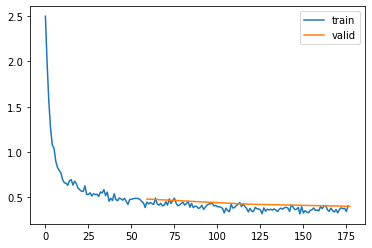

In [22]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp) # because we are dividing the gradients by a possibly small number, 
                                                                                      #  we generally have to decrease the learning rate
learn.fit(3)

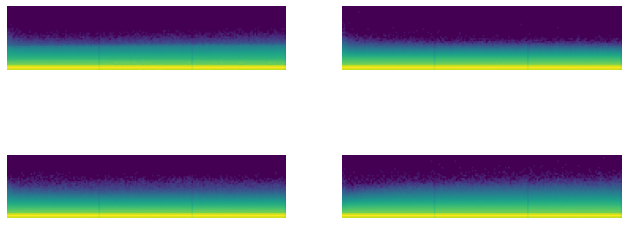

In [23]:
astats.color_dim()

### Adam

In [24]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data) # here we can initialize with zeroes because we are unbiasing further below 
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1))) # remember we are keeping track of self. i in the SGD class
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.791,0.583,0,train
0.840,0.429,0,eval
0.869,0.360,1,train
0.858,0.381,1,eval
0.886,0.312,2,train
0.874,0.345,2,eval


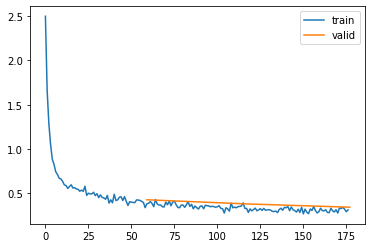

In [25]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam) # same kind of learning rate that RMSProp needs because here also we are doing the division
learn.fit(3)

## Schedulers

We've already seen how we can easily write a custom LR-adjusting callback (for the learning rate finder) or `Learner`, or can use the predefined PyTorch schedulers. We'll use the predefined ones for now since there's nothing new to learn in implementing them ourselves.

#### Reminder from Learner notebook

In [22]:
class LRFinderCB(Callback):
    def __init__(self, lr_mult=1.3): fc.store_attr()
    
    def before_fit(self, learn):
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if loss > self.min*3: raise CancelFitException()
        ########### this is the most important line ##############
        for g in learn.opt.param_groups: g['lr'] *= self.lr_mult
        ########### this is the most important line ##############

#### End of reminder from Learner notebook

In [23]:
lr_scheduler

<module 'torch.optim.lr_scheduler' from '/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py'>

In [24]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [25]:
' '.join(filter(lambda x: x[0].isupper() and x[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [26]:
TrainLearner??

Init signature:
TrainLearner(
    model,
    dls=(0,),
    loss_func=<function mse_loss at 0x7fb0917f5c10>,
    lr=0.1,
    cbs=None,
    opt_func=<class 'torch.optim.sgd.SGD'>,
)
Docstring:      <no docstring>
Source:        
class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()
File:           /notebooks/course22p2/nbs/miniai/learner.py
Type:           type
Subclasses:     MomentumLearner


As we can see, if we don't provide an optimizer to the learner, it will default to torch.optim.sgd.SGD

In [27]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [28]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0]!='_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [29]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [31]:
param = next(iter(learn.model.parameters()))
param.shape

torch.Size([8, 1, 3, 3])

In [33]:
get_model??

Signature:
get_model(
    act=<class 'torch.nn.modules.activation.ReLU'>,
    nfs=None,
    norm=None,
)
Docstring: <no docstring>
Source:   
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1],10, act=None, norm=False, bias=True),
                         nn.Flatten()).to(def_device)
File:      /notebooks/course22p2/nbs/miniai/init.py
Type:      function


In [32]:
st = opt.state[param] # the key of the state dictionnary is a tensor 

In [ ]:
st

{'momentum_buffer': None}

This is an exponentially weighted moving average (right now it's None because we haven't started training). Previously we stored the lerps in an attribute of the tensors, here we store them in a dict.

In [ ]:
len(opt.param_groups)

1

In [ ]:
pg = opt.param_groups[0]

One group contains of all of the details. It is a dict as well. We can get the keys using list():

In [ ]:
list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach',
 'differentiable']

In [34]:
dd = {'a':1,'b':2}
list(dd)

['a', 'b']

There can be multiple parameter groups, because for transfer learning we want to use different learning rates for different groups of layers.

In [35]:
lr_scheduler

<module 'torch.optim.lr_scheduler' from '/usr/local/lib/python3.9/dist-packages/torch/optim/lr_scheduler.py'>

In [36]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100) # we need to pass the optimizer to the scheduler because the scheduler will change the lr of the optimizer

In [37]:
sched.base_lrs # because remember we did set lr=6e-3 during the instantiation of our TrainLearner above

[0.006]

It's a list because we could have different lrs for each param group

In [41]:
sched.get_last_lr()

[0.006]

In [42]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step() # this is what causes  the scheduler to adjust the learning rate
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

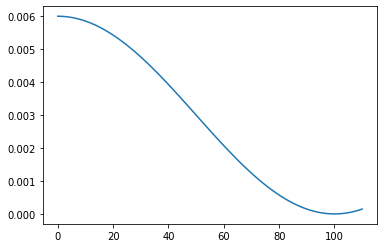

In [43]:
sched_lrs(sched, 110)

We can see it is going back up again because it is a cosine curve.

### Scheduler callbacks

In [44]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt) # schedo = scheduling object. Here we are instantiating the scheduler, 
                                                                     # T_max has already been passed thanks to partial (see code further below)
    def _step(self, learn):
        if learn.training: self.schedo.step() # what is going to call step is after_batch in subclasses of BaseSchedCB (see cell below)

In [45]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn) # if we want to update the lr at every batch

In [46]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn 
    def after_fit(self, learn): self.learn = None

In [47]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k:[] for k in self.d}
        self.pg = learn.opt.param_groups[0] # it has one param group to track se we just pick the first one
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self)) # v is a function (for example _lr defined below)

    def plot(self):
        for k,v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [48]:
def _lr(cb): return cb.pg['lr'] # the attribute pg is defined in the before_fit method of the RecorderCB above

In [50]:
len(dls.train) # number of mini batches in the training data loader

59

In [51]:
tmax = 3 * len(dls.train) # because we are going to fit for 3 epochs 
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.806,0.525,0,train
0.848,0.415,0,eval
0.878,0.331,1,train
0.879,0.331,1,eval
0.897,0.282,2,train
0.881,0.317,2,eval


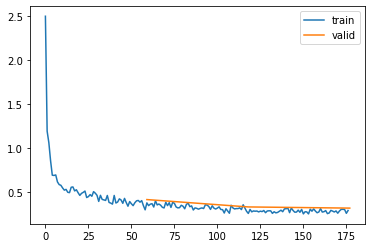

In [52]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched),rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

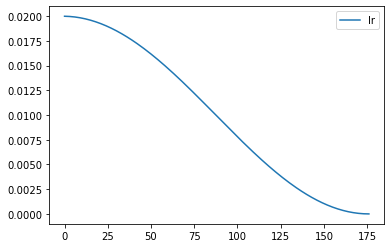

In [ ]:
rec.plot()

In [54]:
len(dls.train) * 3 # number of batches over 3 epochs

177

Now we're going to step after each epoch:

In [ ]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.809,0.517,0,train
0.857,0.382,0,eval
0.881,0.327,1,train
0.875,0.339,1,eval
0.899,0.275,2,train
0.887,0.307,2,eval


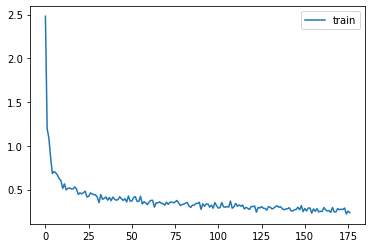

In [ ]:
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
set_seed(42)
xtra = [EpochSchedCB(sched),rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

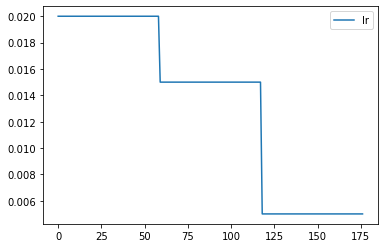

In [ ]:
rec.plot()

### 1cycle training

[Paper](https://arxiv.org/abs/1803.09820) by Leslie Smith.

Let's now also grab the beta for momentum because we will be using AdamW:

In [ ]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.765,0.662,0,train
0.822,0.546,0,eval
0.862,0.376,1,train
0.856,0.413,1,eval
0.888,0.304,2,train
0.879,0.333,2,eval
0.904,0.257,3,train
0.901,0.279,3,eval
0.924,0.210,4,train
0.906,0.267,4,eval


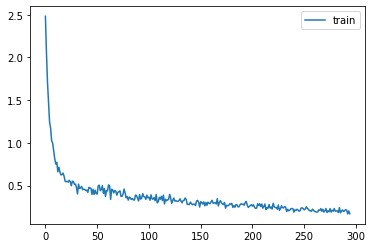

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

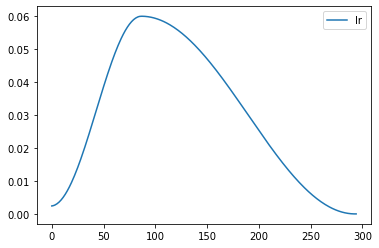

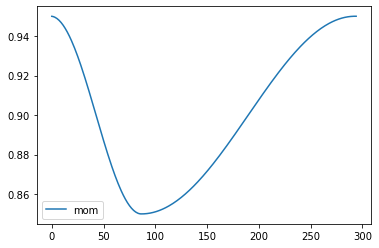

In [ ]:
rec.plot()

Starting with a low lr (warmup) is important if we don't have a perfectly initialized model (which is the case most of the time for more complex models).
When the lr is high, we don't want as much momentum.
As we get closer to the optimal weights, we generally want to decrease the lr. 

Papers for correct initialization:
- Resnets: fixup initialization: residual learning without normalization
- Transformers: T-fixup

## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()